In [1]:
import numpy as np
import collections
import os
import matplotlib.pyplot as plt

INFO_FIELDS = ['locus', 'rsid', 'stat', 'ld', 'causality']
class LDResult(collections.namedtuple('_LDResult', INFO_FIELDS)):
    __slots__ = ()

def read_causal_rsids(causal_snps_file):
    causal_rsid = dict()
    with open(causal_snps_file, 'r') as mfile:
        rsidlist = list()
        locus_name = ''
        for line in mfile:
            if line.startswith('#'):
                causal_rsid[locus_name] = rsidlist
            else:
                mline =  line.split()
                if mline[0].startswith('Causality'):
                    locus_name = mline[1]
                    rsidlist = list()
                else:
                    rsidlist.append(mline[0])
        causal_rsid[locus_name] = rsidlist
    return causal_rsid

In [194]:
nsim = 10
startsim = 41
basedir='/scratch/sbanerj/quasi_laplace_gwas'
blore_path = 'blore/meta_without_feature/zmax{:d}_mu{:s}_pi0.01_sig0.01/blore_meta_res/{:s}.gen.res'
probit_path = 'pimass/c{:d}_1e6_probit/output/{:s}.mcmc.txt'
linear_path = 'pimass/c{:d}_1e6_linear/output/{:s}.mcmc.txt'
finemap_path = 'finemap/c{:d}/{:s}.snp'
zmax = 2
muvar = '0'
whichplot = {'blore': True, 
             'probit': True,
             'linear': True,
             'finemap': False}

In [133]:
def read_blore_res(simdir, filepath, locusprefixes, causal_rsids, zmax, muvar):
    thisres = list()
    for locus in locusprefixes:
        locusres = list()
        outfilepath = filepath.format(zmax, muvar, locus)
        outfile = os.path.join(simdir, outfilepath)
        causals = causal_rsids[locus]
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                mline_split = mline.split()
                rsid = mline_split[0]
                prob = float(mline_split[4])
                causality = 1 if rsid in causals else 0
                mres = LDResult(locus = locus,
                                rsid = rsid,
                                stat = prob,
                                ld = 1,
                                causality = causality)
                locusres.append(mres)
        thisres.append(locusres)
    return thisres

def read_pimass_res(simdir, filepath, locusprefixes, causal_rsids, zmax):
    thisres = list()
    for locus in locusprefixes:
        locusres = list()
        outfilepath = filepath.format(zmax, locus)
        outfile = os.path.join( simdir, outfilepath )
        causals = causal_rsids[locus]
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                mline_split = mline.split()
                rsid = mline_split[0].strip()
                prob = float(mline_split[3])
                causality = 1 if rsid in causals else 0
                mres = LDResult(locus = locus,
                                rsid = rsid,
                                stat = prob,
                                ld = 1,
                                causality = causality)
                locusres.append(mres)
        thisres.append(locusres)
    return thisres

def read_finemap_res(simdir, filepath, locusprefixes, causal_rsids, zmax):
    thisres = list()
    for locus in locusprefixes:
        locusres = list()
        outfilepath = filepath.format(zmax, locus)
        outfile = os.path.join( simdir, outfilepath )
        causals = causal_rsids[locus]
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                mlinesplit = mline.split()
                rsid = mlinesplit[1]
                prob = float(mlinesplit[3])
                causality = 1 if rsid in causals else 0
                mres = LDResult(locus = locus,
                                rsid = rsid,
                                stat = prob,
                                ld = 1,
                                causality = causality)
                locusres.append(mres)
        thisres.append(locusres)
    return thisres

In [134]:
def read_locusprefixes(locusfile):
    with open(locusfile, 'r') as mfile:
        locusprefixes = mfile.readlines()
    locusprefixes = [x.strip() for x in locusprefixes]
    return locusprefixes

blore = list()
pimass_probit = list()
pimass_linear = list()
finemap = list()

locusfile = os.path.join(basedir, 'LOCUSNAMES.MAXSNPS')
locusprefixes = read_locusprefixes(locusfile)

for sim in range(startsim, startsim + nsim):
    
    simname = 'sim{:03d}'.format(sim)
    simdir = os.path.join(basedir, 'simulations', simname)

    causal_snps_file = os.path.join(simdir, 'samples', 'causal.snplist')
    causal_rsids = read_causal_rsids(causal_snps_file)
    
    if whichplot['blore']:
        thisres = read_blore_res(simdir, blore_path, locusprefixes, causal_rsids, zmax, muvar)
        blore.append(thisres)
        
    if whichplot['probit']:
        thisres = read_pimass_res(simdir, probit_path, locusprefixes, causal_rsids, zmax)
        pimass_probit.append(thisres)
        
    if whichplot['linear']:
        thisres = read_pimass_res(simdir, linear_path, locusprefixes, causal_rsids, zmax)
        pimass_linear.append(thisres)
        
    if whichplot['finemap']:
        thisres = read_finemap_res(simdir, finemap_path, locusprefixes, causal_rsids, zmax)
        finemap.append(thisres)

In [196]:
import precisionld_recall as roc
import precision_recall_scores as newroc

def precision_recall_threshold(data, ldcut, nsim, nloci, nsnps):
    # Number of threshold points = number of SNPs in each list
    nsnps = max([len(x) for x in data])
    xvals = np.linspace(0, nsnps, nsnps)
    y1 = list()
    y2 = list()

    for d in data:
        _, _tpr, _ppv, _nsel, _, _, _, _ = newroc.precisionld_recall_curve(d, ldcut)
        _ppv[0] = 1.0
        tpr_est = np.interp(xvals, _nsel, _tpr)
        ppv_est = np.interp(xvals, _nsel, _ppv)
        y1.append(tpr_est)
        y2.append(ppv_est)

    recall        = np.array(y1).mean(axis = 0)
    precision     = np.array(y2).mean(axis = 0)
    recall_err    = np.array(y1).std(axis = 0)
    precision_err = np.array(y2).std(axis = 0)

    return xvals, precision, recall, precision_err, recall_err


def xyplotvals_recall(data, ldcut, nsim, nloci, nsnps):
    xvals = np.linspace(0, nsnps, nsnps)
    #data_flat = [locusres for simres in data for locusres in simres]
    yests = list()
    for d in data:
    #for dflat in data_flat:
        dflat = [x for y in d for x in y]
        #_fpr, _tpr, _precision, _recall, _nselected, _precisionld, _fdr = roc.precisionld_recall_curve(dflat, ldcut)
        #_nselected = np.array(_nselected)
        _fpr, _recall, _precision, _nselected, _, _, _, _ = newroc.precisionld_recall_curve(dflat)
        yest = np.interp(xvals, _nselected, _recall)
        yests.append(yest)
    yests = np.array(yests)
    yvals = yests.mean(axis=0)
    ystd = yests.std(axis=0)
    return (xvals, yvals, ystd)

def xyplotvals_precision(data, ldcut, nsim, nloci, nsnps):
    xvals = np.linspace(0, nsnps, nsnps)
    yests = list()
    for sim in range(nsim):
        _fpr, _tpr, _precision, _recall, _nselected, _precisionld, _fdr = roc.precisionld_recall_curve(data[sim], ldcut)
        _nselected = np.array(_nselected)
        yest = np.interp(xvals, _nselected, _precision)
        yests.append(yest)
    yests = np.array(yests)
    yvals = yests.mean(axis=0)
    ystd = yests.std(axis=0)
    return (xvals, yvals, ystd)


def xyplotvals_prc(data, ldcut, nsim, nloci, nsnps):
    xvals = np.linspace(0, 1, 200)
    yests = list()
    for sim in range(nsim):
        _fpr, _tpr, _precision, _recall, _nselected, _precisionld, _fdr = roc.precisionld_recall_curve(data[sim], ldcut)
        yest = np.interp(xvals, _recall[1:], _precision[1:])
        yests.append(yest)
    yests = np.array(yests)
    yvals = yests.mean(axis=0)
    ystd = yests.std(axis=0)
    xvals = np.insert(xvals, 0, 0)
    yvals = np.insert(yvals, 0, 1)
    ystd = np.insert(ystd, 0, 0)
    return (xvals, yvals, ystd)

plotvals = collections.defaultdict(lambda:0)
nloci = len(locusprefixes)
nsnps = 18237

if whichplot['blore']:
    newdata = [[y for z in x for y in z] for x in blore]
    plotvals['blore'] = precision_recall_threshold(newdata, 0, nsim, nloci, nsnps)
if whichplot['probit']:
    newdata = [[y for z in x for y in z] for x in pimass_probit]
    plotvals['probit'] = precision_recall_threshold(newdata, 0, nsim, nloci, nsnps)
if whichplot['linear']:
    newdata = [[y for z in x for y in z] for x in pimass_linear]
    plotvals['linear'] = precision_recall_threshold(newdata, 0, nsim, nloci, nsnps)
if whichplot['finemap']:
    newdata = [[y for z in x for y in z] for x in finemap]
    plotvals['finemap'] = precision_recall_threshold(newdata, 0, nsim, nloci, nsnps)

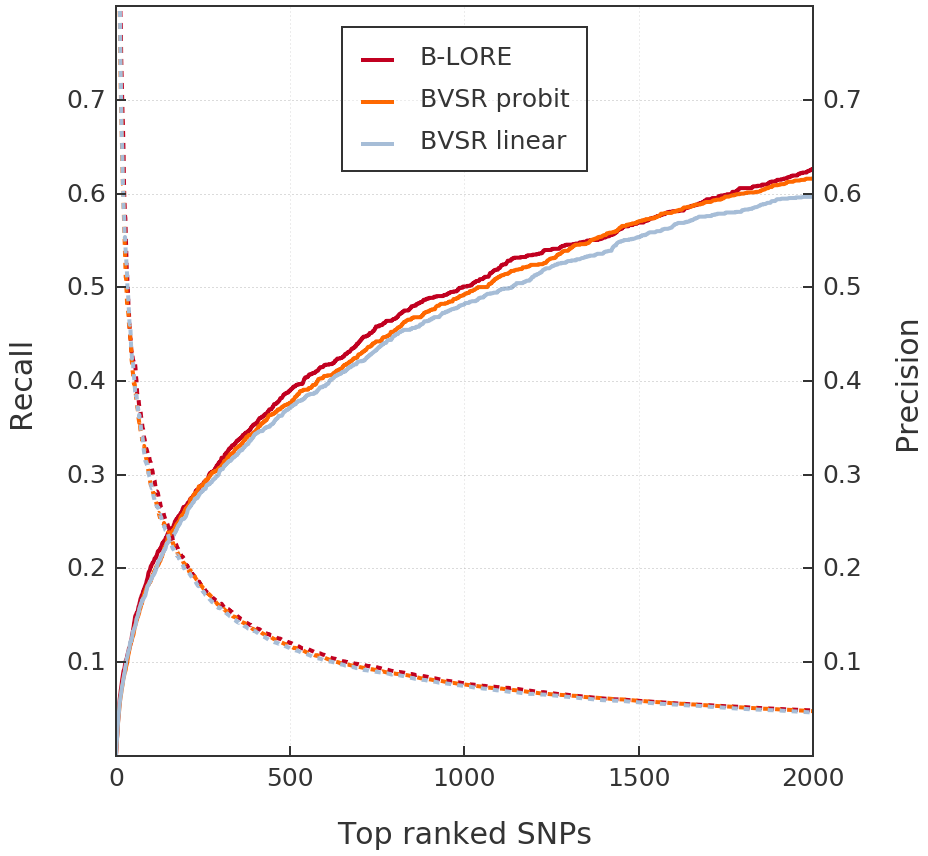

In [239]:
import matplotlib.pyplot as plt

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
colors = kelly_colors_hex
figsize = (13, 12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25


fig = plt.figure(figsize = figsize)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mlabels = {'blore': 'B-LORE',
          'probit':'BVSR probit',
          'linear': 'BVSR linear',
          'finemap': 'FINEMAP'
          }

mcolors = {'blore': colors[4],
           'probit': colors[2],
           'linear': colors[3],
           'finemap': colors[1]
          }

for key in ['blore', 'probit', 'linear', 'finemap']:
    if whichplot[key]:
        data = plotvals[key]
        xvals = data[0]
        yvals = data[2]
        ax1.plot(xvals, yvals, label = mlabels[key], lw = 4, color = mcolors[key])
        yvals = data[1]
        ax2.plot(xvals, yvals, lw = 4, ls = 'dashed', color = mcolors[key])
        
mxlabel = r'Top ranked SNPs'
my1label = r'Recall'
my2label = r'Precision'

ax1.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 30)
ax1.set_ylabel(my1label, {'size': axis_font_size, 'color': bordercolor}, labelpad = 30)
ax2.set_ylabel(my2label, {'size': axis_font_size, 'color': bordercolor}, labelpad = 30)
#ax1.set_title('All loci contain at least one causal SNP', {'size': axis_font_size*1.2, 'color': bordercolor}, y = 1.08)


for ax in [ax1, ax2]:
    
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 0.8)
    ax.set_yticks(np.arange(0.1, 0.8, 0.1))
    #legendtitle = 'SNPs'
    
    h, l = ax.get_legend_handles_labels()
    if len(l) > 0:
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
                           handlelength = 3.0,
                           handletextpad = 2.0,
                           markerscale=5,
                           ncol = 1,
                           frameon = True, borderpad = 1.5, labelspacing = 1.5
                           #title = legendtitle
                          )
        for l in legend.legendHandles:
            l.set_alpha(1)
        lframe = legend.get_frame()
        lframe.set_edgecolor(bordercolor)
        lframe.set_linewidth(borderwidth)
        for fonts in ([legend.get_title()] + legend.texts):
            fonts.set_fontsize(legend_font_size)
            fonts.set_color(bordercolor)

    ax.tick_params(axis='both', which = 'major',
                   length = 10, width = borderwidth, pad=10,
                   labelsize = label_font_size,
                   color = bordercolor,
                   labelcolor = bordercolor,
                   bottom = True, top = False, left = True, right = True
                  )
    for side, border in ax.spines.items():
        border.set_linewidth(borderwidth)
        border.set_color(bordercolor)
    ax.grid(color='dimgray', lw=0.5, alpha=0.5)

plt.tight_layout()

    
#ax1.legend()
plt.show()

In [243]:
newdata = list()
for x in blore:
    newdata += x

In [250]:
namx = int(0.15 * 18237)

2735

In [14]:
pimass_linear_credible = list()
for data in pimass_linear:
    locusprefixes = list(set([x.locus for x in data]))
    for locus in locusprefixes:
        thisres = [x for x in data if x.locus == locus]
        pimass_linear_credible.append(thisres)

In [15]:
pimass_probit_credible = list()
for data in pimass_probit:
    locusprefixes = list(set([x.locus for x in data]))
    for locus in locusprefixes:
        thisres = [x for x in data if x.locus == locus]
        pimass_probit_credible.append(thisres)